<a href="https://colab.research.google.com/github/Riku-KANO/basic-ml-model/blob/main/optimization/TPE_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree-structured Parzen Estimatorによるベイズ最適化
under construction

## Tree structured Parzen Estimator (TPE) とは

## Tree structured Parzen Estimator (TPE) の原理
　まず初めに、問題設定は以下のように設定する。
$$
\newcommand{\argmin}{\mathop{\rm arg~min}\limits}
x^{+}=\argmin_{x∈ℋ} f(x)\\ 
$$

$ℋ$は入力$x$の空間、$f(x)$はブラックボックス関数、$x^{+}$はブラックボックスが出力する最小値の時の入力$x^{+}$である。我々の目標はブラックボックスが最小値を示す時の入力$x^{+}$を求めることを念頭に置いて議論を進めていく。  
<br>
ベイズ最適化において、TPEはガウス過程回帰と同様にEIやPIなどといった獲得関数を計算する。獲得関数を計算する際、ガウス過程回帰は$p(y|x)$をベースとして以下の数式が最大になる$x$を次の探索候補点$x^*$とする。  
<br>
$$\text{EI}_{y^*}(x)=𝔼[\max(y^{*}-y, 0)]=∫^{∞}_{-∞}\max(y^{*}-y, 0)p_M(y|x)dy$$
<br>
ここで、$y^*$は閾値(threshold)であり、多くの場合では今まで得られた中での$y$の最大値が用いられる。また、$p_M(y|x)$はガウス過程モデルが推定する尤度である。
<br>
　一方でTPEでは$p(x|y)$や$p(y)$を用いて獲得関数を計算する(実際には$p(y)$をモデリングすることはないので実質的には$p(x|y)$のみを考えていくことになる)。TPEでは$p(x|y)$は以下のように定義される。  
<br>
\begin{equation}
  p(x|y)=
  \begin{cases}
    l(x) & \text{if} \ y\lt y^{*}, \\
    g(x) & \text{if} \ y\ge y^{*}, \\
  \end{cases}
\end{equation}
<br>
$l(x)$と$g(x)$は（カーネル）密度であり、$y^{*}$は閾値(threshold)である。$y^{*}$を基準としてそれを超える、またはそれを超えないデータの密度を計算(推定)している。そのデータの推定密度を用いて事後確率を計算している。$y^{*}$の選択方法に関しては$\gamma=p(y<y^{*})$となるような$y^{*}$を選択する。$\gamma$は0から1の間の値をとる実数であり、$\gamma=0.5$とした場合はデータが半々になるような$y^{*}$を選択することを指す。つまり$\gamma$は分位値(quantile)である。  
　以上を踏まえると獲得関数は以下のように記述される。  
<br>
$$\text{EI}_{y^{*}}(x)=\int^{y^{*}}_{-∞}(y^{*}-y)p(y|x)dy=\int^{y^{*}}_{-∞}(y^{*}-y)\frac{p(x|y)p(y)}{p(x)}dy$$
<br>
ここで、  
<br>
$$p(x)=\int_{ℝ}p(x|y)p(y)dy=\gamma l(x)+(1-\gamma)g(x)$$
<br>
であり、
<br>
$$\int^{y^{*}}_{-∞}(y^{*}-y)p(x|y)p(y)dy=l(x)\int^{y^{*}}_{-∞}(y^{*}-y)p(y)dy=\gamma y^{*}l(x)-l(x) \int^{y^{*}}_{-∞}p(y)dy$$
<br>
であるので、これらの２式を上式の獲得関数の式に代入すると、以下の式が得られる。  
<br>
$$\text{EI}_{y^{*}}(x)=\frac{\gamma y^{*}l(x)-l(x)\int^{y^{*}}_{-∞}p(y)dy}{\gamma l(x)+(1-\gamma)g(x)}∝\left(\gamma + \frac{g(x)}{l(x)}(1-\gamma)\right)^{-1}$$
<br>
この式から、獲得関数が$g(x)/l(x)$のみに依存しているということがわかる。

## カーネル密度推定
カーネル密度推定はここではsklearnを用いて行うことにする。

### カーネル密度推定とは
カーネル密度推定とはデータの分布をノンパラメトリックに分布を予測する手法である。正規分布や二項分布はパラメトリックモデルと呼ばれているのは、その分布が複数のパラメータのみによって記述されるからである。ノンパラメトリックモデルでは分布を支配するパラメータの存在を仮定しない。  
具体的には$i$番目のデータを$X_i$として表すと以下の式で分布$p$を推定する。
$$\hat{p}=\frac{1}{nh}\sum_{i=1}^{n}K\left(\frac{x-X_i}{h}\right)$$
ここで$K$はカーネル関数, $h$はバンド幅である。この式が意味するように、今まで取得してきたデータ点$X_i$の個数だけカーネル関数を足し合わせることを行う。この処理のイメージとしては、データ点$X_i$の周りに山を作成し、それらを重ね合わせて１つの山($\hat{p}$)を作るイメージとなる。

### カーネルの種類
sklearnで利用できるカーネルの種類は全部で６種類ある。カーネルの形状は次のコードに図示されている。

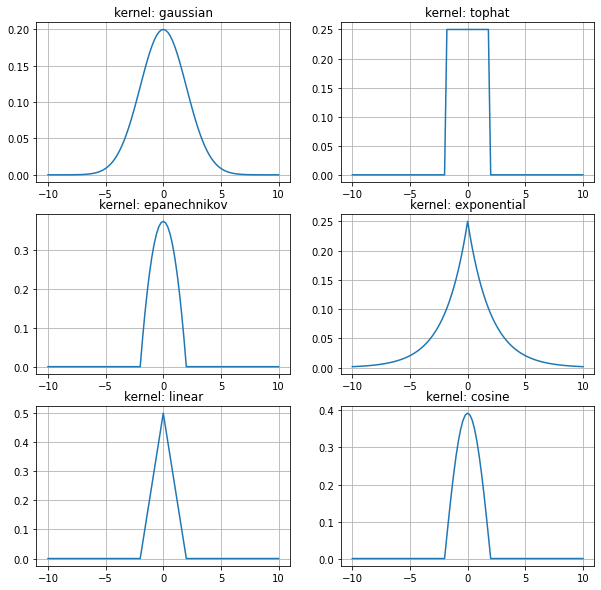

In [11]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
x = np.linspace(-10, 10, 101)
fig, ax=plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
for i, kernel in enumerate(kernels):
  model = KernelDensity(bandwidth=2, kernel=kernel)
  model.fit([[0]])
  ax[i//2, i%2].plot(x, np.exp(model.score_samples(x.reshape(-1, 1))))
  ax[i//2, i%2].set_title(f"kernel: {kernel}")
  ax[i//2, i%2].grid(True)
  
plt.show()

## 最適化

## Reference
[1] https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf  
[2] http://ibis.t.u-tokyo.ac.jp/suzuki/lecture/2015/dataanalysis/L9.pdf  
[3]